In [16]:
import nltk
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sqlalchemy import create_engine

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [18]:
def tokenize(text):
    '''
    Create tokens and then lemmatize the tokens. Useful for including in CountVectorizer
    Parameters:
        text (str): Input text to be tokenized
    '''
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for tok in tokens:
        clean_token = lemmatizer.lemmatize(tok).lower().strip()
        lemmatized_tokens.append(clean_token)
    return lemmatized_tokens

In [19]:
def evaluate_model(trained_model, X_test, y_test, y_pred, column_labels):
    test_result_df = pd.DataFrame(y_test, columns = column_labels)
    pred_result_df = pd.DataFrame(y_pred, columns = column_labels)
    #column = 'related'
    #accuracy = accuracy_score(test_result_df['related'], pred_result_df['related'])
    trained_model_accuracy = trained_model.score(X_test, y_test)
    accuracy_df = pd.DataFrame(data = [], columns = ['Category', 'Accuracy','Precision', 'Recall', 'F1', 'Support'])
    i = 0
    for column_name in column_labels:
        accuracy_score_column = round(accuracy_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        precision_score_column = round(precision_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        recall_score_column = round(recall_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        f1_score_column = round(f1_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        #print(column_name, '----', accuracy_score_column)
        accuracy_df.loc[i] = [column_name, accuracy_score_column, precision_score_column, recall_score_column, f1_score_column, 0]
        i += 1
    return accuracy_df, trained_model_accuracy

In [20]:
db_engine = create_engine('sqlite:////home/prasannaiyer/Projects/NLP_Project/Data/DisasterResponse.db')
msg_df = pd.read_sql_table('Message_Category', db_engine)

In [21]:
columnn_labels = msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]

In [22]:
for column_name in msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]:
    msg_df[column_name] = msg_df[column_name].astype('int')

In [23]:
X = msg_df['message'].values
y = msg_df.loc[:, ~msg_df.columns.isin(['id', 'genre', 'message', 'original'])].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
pipeline_trained_model = pickle.load(open('/data2/home/prasannaiyer/Projects/NLP_Project/Code/pipeline_model.sav', 'rb'))
pred_pipeline = pipeline_trained_model.predict(X_test)
pipeline_model_accuracy_df, pipeline_model_overall_acc = evaluate_model(pipeline_trained_model, X_test, y_test, pred_pipeline, columnn_labels)

/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/skl

In [25]:
#model_filename = open('/data2/home/prasannaiyer/Projects/NLP_Project/Code/cv_model.sav', 'rb')
cv_trained_model = pickle.load(open('/data2/home/prasannaiyer/Projects/NLP_Project/Code/cv_model.sav', 'rb'))
pred_cv = cv_trained_model.predict(X_test)
cv_model_accuracy_df, cv_model_overall_acc = evaluate_model(cv_trained_model, X_test, y_test, pred_cv, columnn_labels)

/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [33]:
print('Accuracy: Pipeline = {:.2f}% and Gridsearch = {:.2f}%'.format(pipeline_model_overall_acc*100, cv_model_overall_acc*100))

Accuracy: Pipeline = 30.33% and Gridsearch = 80.21%


/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'related'),
  Text(1, 0, 'request'),
  Text(2, 0, 'offer'),
  Text(3, 0, 'aid_related'),
  Text(4, 0, 'medical_help'),
  Text(5, 0, 'medical_products'),
  Text(6, 0, 'search_and_rescue'),
  Text(7, 0, 'security'),
  Text(8, 0, 'military'),
  Text(9, 0, 'child_alone'),
  Text(10, 0, 'water'),
  Text(11, 0, 'food'),
  Text(12, 0, 'shelter'),
  Text(13, 0, 'clothing'),
  Text(14, 0, 'money'),
  Text(15, 0, 'missing_people'),
  Text(16, 0, 'refugees'),
  Text(17, 0, 'death'),
  Text(18, 0, 'other_aid'),
  Text(19, 0, 'infrastructure_related'),
  Text(20, 0, 'transport'),
  Text(21, 0, 'buildings'),
  Text(22, 0, 'electricity'),
  Text(23, 0, 'tools'),
  Text(24, 0, 'hospitals'),
  Text(25, 0, 'shops'),
  Text(26, 0, 'aid_centers'),
  Text(27, 0, 'other_infrastructure'),
  Text(28, 0, 'weather_related'),
  Text

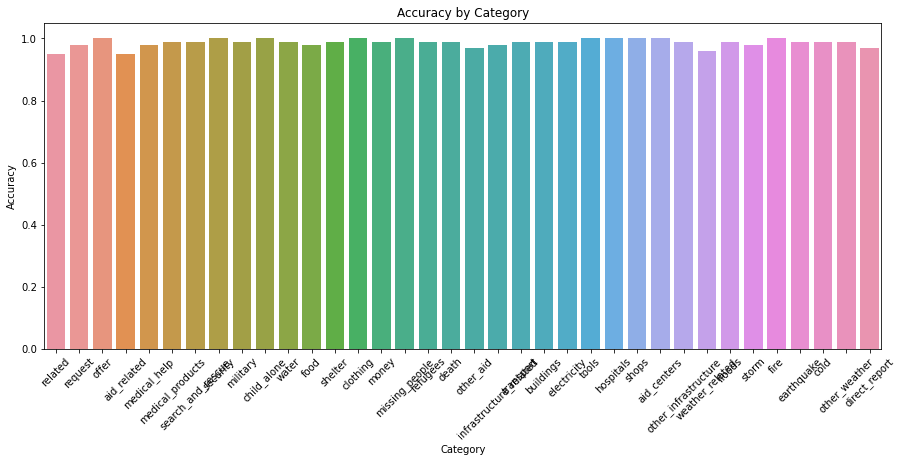

In [26]:
fig = plt.figure(figsize = (15, 6))
ax = sns.barplot(cv_model_accuracy_df['Category'], cv_model_accuracy_df['Accuracy'])
ax.set_title('Accuracy by Category')
plt.xticks(rotation=45)